In this notebook, we make figures summarizing the outputs of a pipeline per galaxy

In [88]:
import os
import sys
import glob
import numpy as np
from tqdm import trange
from astropy.io import fits
from astropy.table import Table, vstack
from astropy.convolution import convolve, Gaussian1DKernel
import astropy.units as u
import astropy.coordinates as coord
import matplotlib
import matplotlib.pyplot as plt
from astropy.table import Column
from tqdm import trange
import pandas as pd
import fitsio
from astropy.table import Table, vstack
from astropy import units as u
from astropy.coordinates import SkyCoord
from easyquery import Query, QueryMaker
from scipy.stats import binomtest
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import LogNorm
from matplotlib.colors import ListedColormap, BoundaryNorm
import h5py
from astropy.cosmology import Planck18
import glob
from matplotlib.lines import Line2D
from astropy.wcs import WCS


mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

rootdir = '/global/u1/v/virajvm/'
sys.path.append(os.path.join(rootdir, 'DESI2_LOWZ/desi_dwarfs/code'))

from desi_lowz_funcs import make_subplots, match_c_to_catalog, print_radecs
from desi_lowz_funcs import calc_normalized_dist
from desi_lowz_funcs import find_objects_nearby, process_img
from construct_dwarf_galaxy_catalogs import process_sga_matches


In [4]:
from consolidate_photometry import consolidate_new_photo, consolidate_positions_and_shapes

In [1]:
def do_consolidate(cat,sample):
    '''
    Here we consolidate the photo
    '''

    cat = consolidate_new_photo(cat,sample=sample, use_pcnn=False)

    cat = cat[cat["PHOTO_MASKBIT"] == 0]

    ra_tgt = cat["RA"].data
    dec_tgt = cat["DEC"].data
    
    cat = consolidate_positions_and_shapes(cat)

    cat["RA_TARGET"] = ra_tgt
    cat["DEC_TARGET"] = dec_tgt
    
    return cat

In [2]:
## load the catalogs!

bgsb_cat = Table.read("/pscratch/sd/v/virajvm/catalog_dr1_dwarfs/iron_photometry/iron_BGS_BRIGHT_shreds_catalog_w_aper_mags.fits")
bgsf_cat = Table.read("/pscratch/sd/v/virajvm/catalog_dr1_dwarfs/iron_photometry/iron_BGS_FAINT_shreds_catalog_w_aper_mags.fits")
lowz_cat = Table.read("/pscratch/sd/v/virajvm/catalog_dr1_dwarfs/iron_photometry/iron_LOWZ_shreds_catalog_w_aper_mags.fits")
elg_cat = Table.read("/pscratch/sd/v/virajvm/catalog_dr1_dwarfs/iron_photometry/iron_ELG_shreds_catalog_w_aper_mags.fits")

#get the consolidate photometry!!
bgsb_cat = do_consolidate(bgsb_cat,sample="BGS_BRIGHT")
bgsf_cat = do_consolidate(bgsf_cat,sample="BGS_FAINT")
lowz_cat = do_consolidate(lowz_cat,sample="LOWZ")
elg_cat = do_consolidate(elg_cat,sample="ELG")


NameError: name 'Table' is not defined

In [89]:

import requests
from matplotlib.patches import Ellipse, Circle



session = requests.Session()


def save_full_model_cutouts(ra,dec,img_path,session, size=350, timeout = 30):
    url_prefix = 'https://www.legacysurvey.org/viewer/'
    
    url = url_prefix + f'cutout.fits?ra={ra}&dec={dec}&size=%s&'%size

    url += 'layer=ls-dr9-model&pixscale=0.262&bands=grz'

    try:
        resp = session.get(url, timeout=timeout)
        resp.raise_for_status()  # Raise error for bad status codes
        # Save the FITS file
        with open(img_path, "wb") as f:
            f.write(resp.content)
    
        #load the wcs and image data
        # img_data = fits.open(img_path)
        # data_arr = img_data[0].data
        # wcs = WCS(fits.getheader( img_path ))
    except:
        print("getting coadd image data failed!")
        print(url)
    
    return

def make_one_panel_dwarf(ax, catalog, tgid,scale_f=5,get_model=False,savefig=False, bar_size_arc = 30,plot_label=True):

    idx = np.where( catalog["TARGETID"] == tgid )[0][0]

    print(tgid)
    
    file_path = catalog["FILE_PATH"][idx]
    img_path = catalog["IMAGE_PATH"][idx]

    ra,dec = catalog["RA_TARGET"][idx], catalog["DEC_TARGET"][idx]

    zred = catalog["Z"][idx]

    #get the source photometry, 
    g_old, r_old, z_old = catalog["MAG_G"][idx], catalog["MAG_R"][idx], catalog["MAG_Z"][idx]
    g_new, r_new, z_new = catalog["MAG_G_BEST"][idx], catalog["MAG_R_BEST"][idx], catalog["MAG_Z_BEST"][idx]

    #choose the size of the image?
    #take the half light diameter, and times 3?
    max_axis = int( catalog["R50_R"][idx] * 6 /0.262)

    reconst = np.load(file_path + "/final_reconstruct_galaxy.npy")

    ##get the tractor source model
    source_model = np.load(file_path + "/tractor_source_model.npy")

    #get image and wcs infno
    img_path = catalog[idx]["IMAGE_PATH"]
    hdus = fits.open(img_path)
    img_data = hdus[0].data
    wcs = WCS(fits.getheader( img_path))

    # maybe show the Tractor Model?
    #get the
    full_model_path = f"/pscratch/sd/v/virajvm/trash/full_dwarf_tractor_models/trac_model_{tgid}.fits"

    if get_model:
        if os.path.exists(full_model_path) == False:
            save_full_model_cutouts(ra,dec,full_model_path,session, size=max_axis, timeout = 30)
        
        #read in the model
        full_model = fits.open(full_model_path)[0].data
    else:
        full_model = np.ones_like(img_data)
    

    print(max_axis, img_data.shape, full_model.shape)

    max_axis = np.min([max_axis, img_data.shape[1], full_model.shape[1] ])

    rgb_img, shift = process_img(img_data, cutout_size = max_axis, org_size = np.shape(img_data)[1], return_shift=True )
    source_img, _ = process_img(source_model, cutout_size = max_axis, org_size = np.shape(img_data)[1], return_shift=True )
    reconst_img, _ = process_img(reconst, cutout_size = max_axis, org_size = np.shape(img_data)[1], return_shift=True )
    model_img, _ = process_img(full_model,  cutout_size = max_axis, org_size = np.shape(full_model)[1], return_shift=True   )

    fsize = 13
    fs_col = "white"
    yloc = 0.95

    #at bottom, show the RA,DEC of this cutout  
    # ax[0].set_title(f"TARGETID = {tgid}",fontsize = 12)
    ax[3].imshow(rgb_img, origin='lower',rasterized=True)
    ax[3].text(0.5,yloc,f"({ra:.3f}, {dec:.3f}), z = {zred:.3f}",size = fsize-1,
               transform=ax[3].transAxes, va='top',ha="center",color = fs_col,zorder = 1)
    
    ax[2].imshow(model_img, origin="lower",rasterized=True)

    ax[1].imshow(source_img, origin="lower",zorder = 0,rasterized=True)
        #top show the grz magnitudes of these objects
    ax[1].text(0.5,yloc,r"$grz$ = (%.1f, %.1f, %.1f)"%(g_old, r_old, z_old),size = fsize,
               transform=ax[1].transAxes, va='top',ha="center",color = fs_col,zorder = 1)


    # ax[0].set_ylabel(f"{targetid}",fontsize = 13)
    
    ax[0].imshow(reconst_img, origin="lower",rasterized=True)
    ax[0].text(0.5,yloc,r"$grz$ = (%.1f, %.1f, %.1f)"%(g_new, r_new, z_new),size = fsize,
               transform=ax[0].transAxes, va='top',ha="center",color = fs_col)


    ## show the ellipse !!
    ra_cen, dec_cen = catalog["RA"][idx], catalog["DEC"][idx]
    r50_pix = catalog["R50_R"][idx]/0.262
    shape_params = catalog["SHAPE_PARAMS"][idx]
    aper_xcen, aper_ycen,_ = wcs.all_world2pix(ra_cen,dec_cen,0,1)

    aper_xcen -= shift
    aper_ycen -= shift

    #we need to shift the center!!

    ell = Ellipse((aper_xcen, aper_ycen), 2 * scale_f * r50_pix, 2 * scale_f * r50_pix * shape_params[0], angle = shape_params[1] - 90,
                  facecolor='none', edgecolor="white", lw=1, ls="-", alpha=0.75)
    ax[0].add_patch(ell)
    
    for axi in ax:
        axi.set_xticks([])
        axi.set_yticks([])

    #plot the horizontal bar plotting 30''
    fs=12
    bar_size = bar_size_arc/0.262
    bar_start = 0.07*np.shape(rgb_img)[0]
    y_bar = 0.07*np.shape(rgb_img)[0]
    
    for i in range(4):
        ax[i].plot([bar_start, bar_start+bar_size], [y_bar,y_bar],color = "white",lw = 1)
        
    ax[3].text( bar_start + 0.5*bar_size, y_bar*1.15, f"{bar_size_arc:d}''",fontsize = fs,color = "white", ha='center')

    ##let us draw a circle indicating the DESI fiber
    circle = Circle( (rgb_img.shape[1]/2, rgb_img.shape[1]/2),3, color='red', fill=False, linewidth=1.5,ls ="-")    
    ax[3].add_patch(circle)

    #add label
    if plot_label:
    
        ax[0].set_ylabel("Our Reconstruction",fontsize = fsize+1)
        ax[1].set_ylabel("DESI Source Tractor Model",fontsize = fsize+1)    
        ax[2].set_ylabel("Tractor Model",fontsize = fsize+1)   
        ax[3].set_ylabel(r"$grz$ image",fontsize = fsize+1)    
        
        
    
    if savefig:
        plt.savefig(f"plots/summary_objs/model_{tgid}.png",bbox_inches="tight",dpi=150)

    plt.show()
        
    return

    
    
    

39627752084603161
371 (3, 1229, 1229) (3, 364, 364)


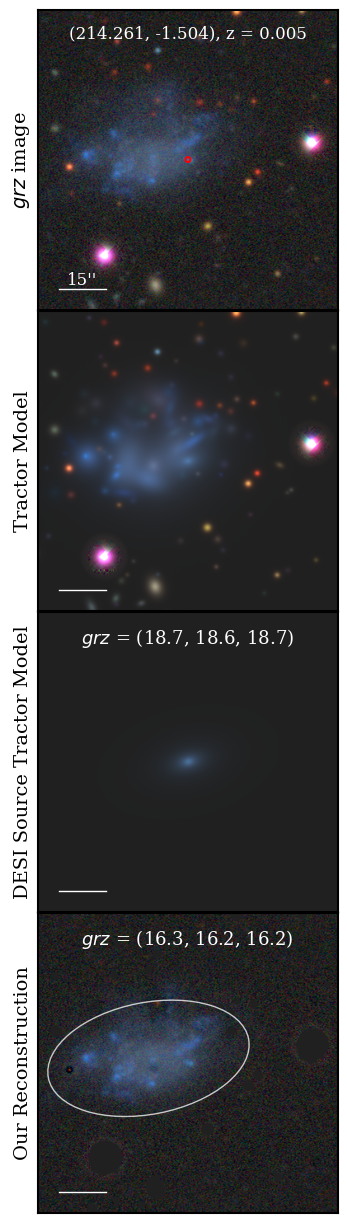

In [91]:

ax = make_subplots(ncol = 1, nrow = 4,row_spacing = 0.01)

make_one_panel_dwarf(ax, bgsb_cat, 39627752084603161, scale_f=2,get_model=True,savefig=True,bar_size_arc = 15,plot_label=True)


39627600171107076
105 (3, 1201, 1201) (3, 105, 105)


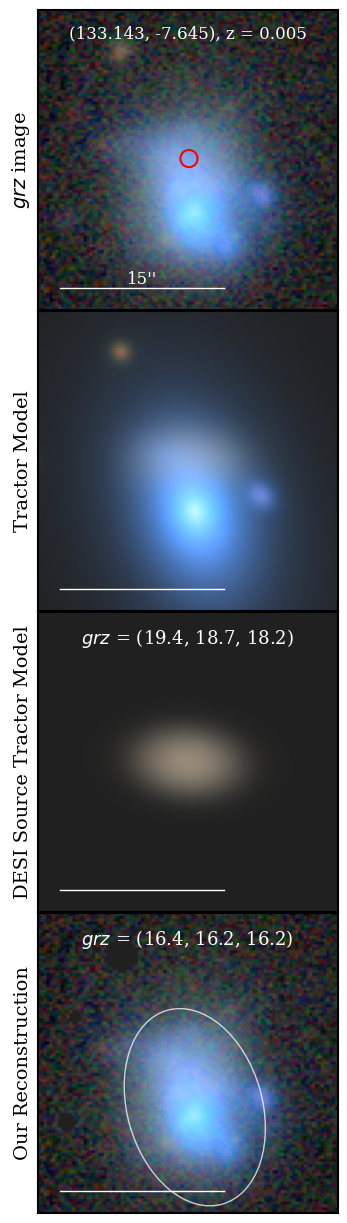

In [97]:

ax = make_subplots(ncol = 1, nrow = 4,row_spacing = 0.01)

make_one_panel_dwarf(ax, bgsb_cat, 39627600171107076, scale_f=2, get_model=True, savefig=True,bar_size_arc = 15,plot_label=True)


39627869990684670
179 (3, 350, 350) (3, 179, 179)


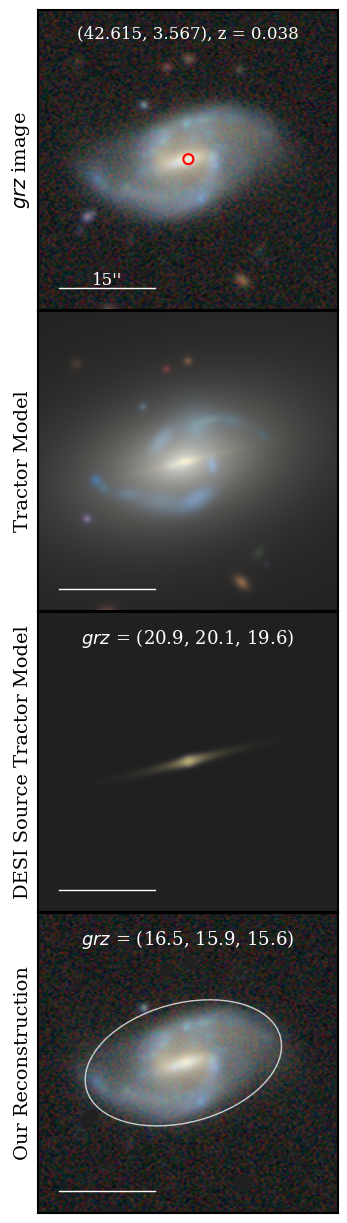

In [98]:

ax = make_subplots(ncol = 1, nrow = 4,row_spacing = 0.01)

make_one_panel_dwarf(ax, bgsf_cat, 39627869990684670, scale_f=2, get_model=True, savefig=True,bar_size_arc = 15,plot_label=True)


39628242323243938
161 (3, 350, 350) (3, 161, 161)


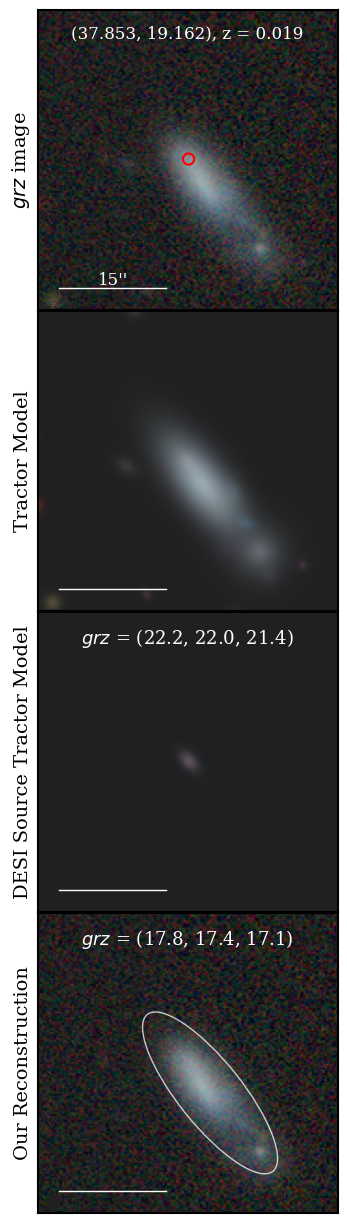

In [99]:

ax = make_subplots(ncol = 1, nrow = 4,row_spacing = 0.01)

make_one_panel_dwarf(ax, elg_cat, 39628242323243938, scale_f=2, get_model=True, savefig=True,bar_size_arc = 15,plot_label=True)


2706316862685184
222 (3, 350, 350) (3, 222, 222)


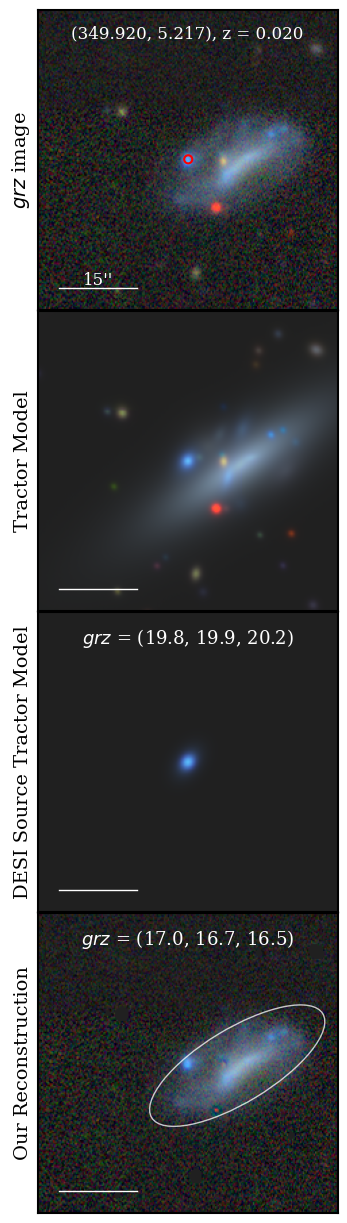

In [100]:

ax = make_subplots(ncol = 1, nrow = 4,row_spacing = 0.01)

make_one_panel_dwarf(ax, lowz_cat, 2706316862685184, scale_f=2, get_model=True, savefig=True,bar_size_arc = 15,plot_label=True)


2706236185247745
109 (3, 350, 350) (3, 109, 109)


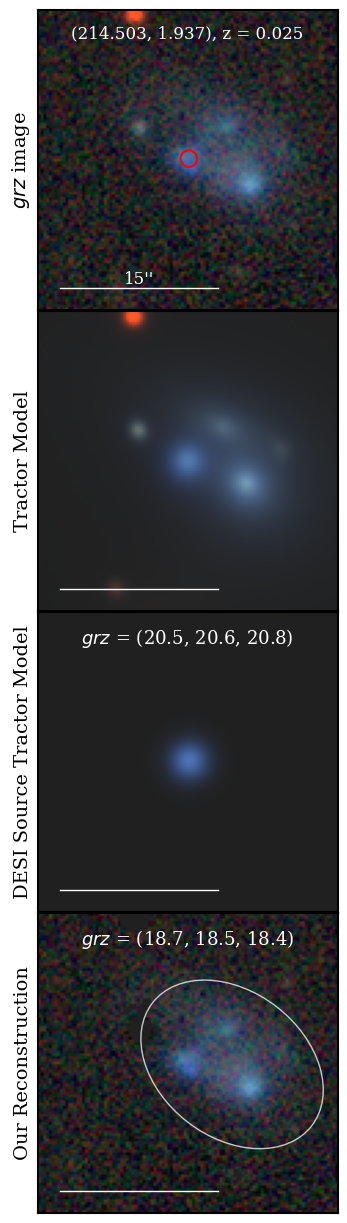

In [101]:

ax = make_subplots(ncol = 1, nrow = 4,row_spacing = 0.01)

make_one_panel_dwarf(ax, lowz_cat, 2706236185247745, scale_f=2, get_model=True, savefig=True,bar_size_arc = 15,plot_label=True)
